## Candy Classification
- Authors: Martin Avila & Hadson Barbosa 

This project presents a complete pipeline for classifying candies using a custom dataset. From dataset creation to model development and evaluation, the entire classification process was implemented from scratch.

Folders:

- database: Dataset of images.
- docs: Auxiliary images.
- utils: .py files containing classes or plots.
- scripts: Auxiliary algorithms.
- models: Classification models

In [14]:
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


### 1. Dataset Creation

In [8]:
# List of classes that are going to be use in the project.
class_codification_tabel = [('banana',0), ('bear',1), ('blackberry',2), 
                            ('brick',3), ('car',4), ('mouth',5),
                            ('plane',6), ('strawberry',7), ('watermelon',8), 
                            ('worm',9)
                            ]
classes = ['banana', 'bear','blackberry', 'brick', 'car', 'mouth', 'plane', 'strawberry', 'watermelon', 'worm'] 
print(len(class_codification_tabel))

10


### Adjusting Images
- After deciding on the subject, we captured 10 black-and-white pictures for each class using a Samsung S21 FE.
- Additionally, we resized the images to a resolution of 256x256 pixels to standardize the dataset for further processing.

In [2]:
from scripts.mosaico_generator import show_mosaic_images 
from scripts.resize_images import resize_images

input_dir = '/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes'
output_dir = '/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized'
target_size = (256, 256)

resize_images(input_dir, output_dir ,target_size)

Resized: /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes/plane_class_06/06-04-V1-B.jpg -> /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized/plane_class_06/06-04-V1-B.jpg
Resized: /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes/plane_class_06/06-02-V1-W.jpg -> /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized/plane_class_06/06-02-V1-W.jpg
Resized: /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes/plane_class_06/06-05-V2-B.jpg -> /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized/plane_class_06/06-05-V2-B.jpg
Resized: /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes/plane_class_06/06-02-V2-B.jpg -> /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized/plane_class_06/06-02-V2-B.jpg
Resized: /home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/dataset/classes/plane_class_06/06-05-V1-W.jpg -> /home/mab

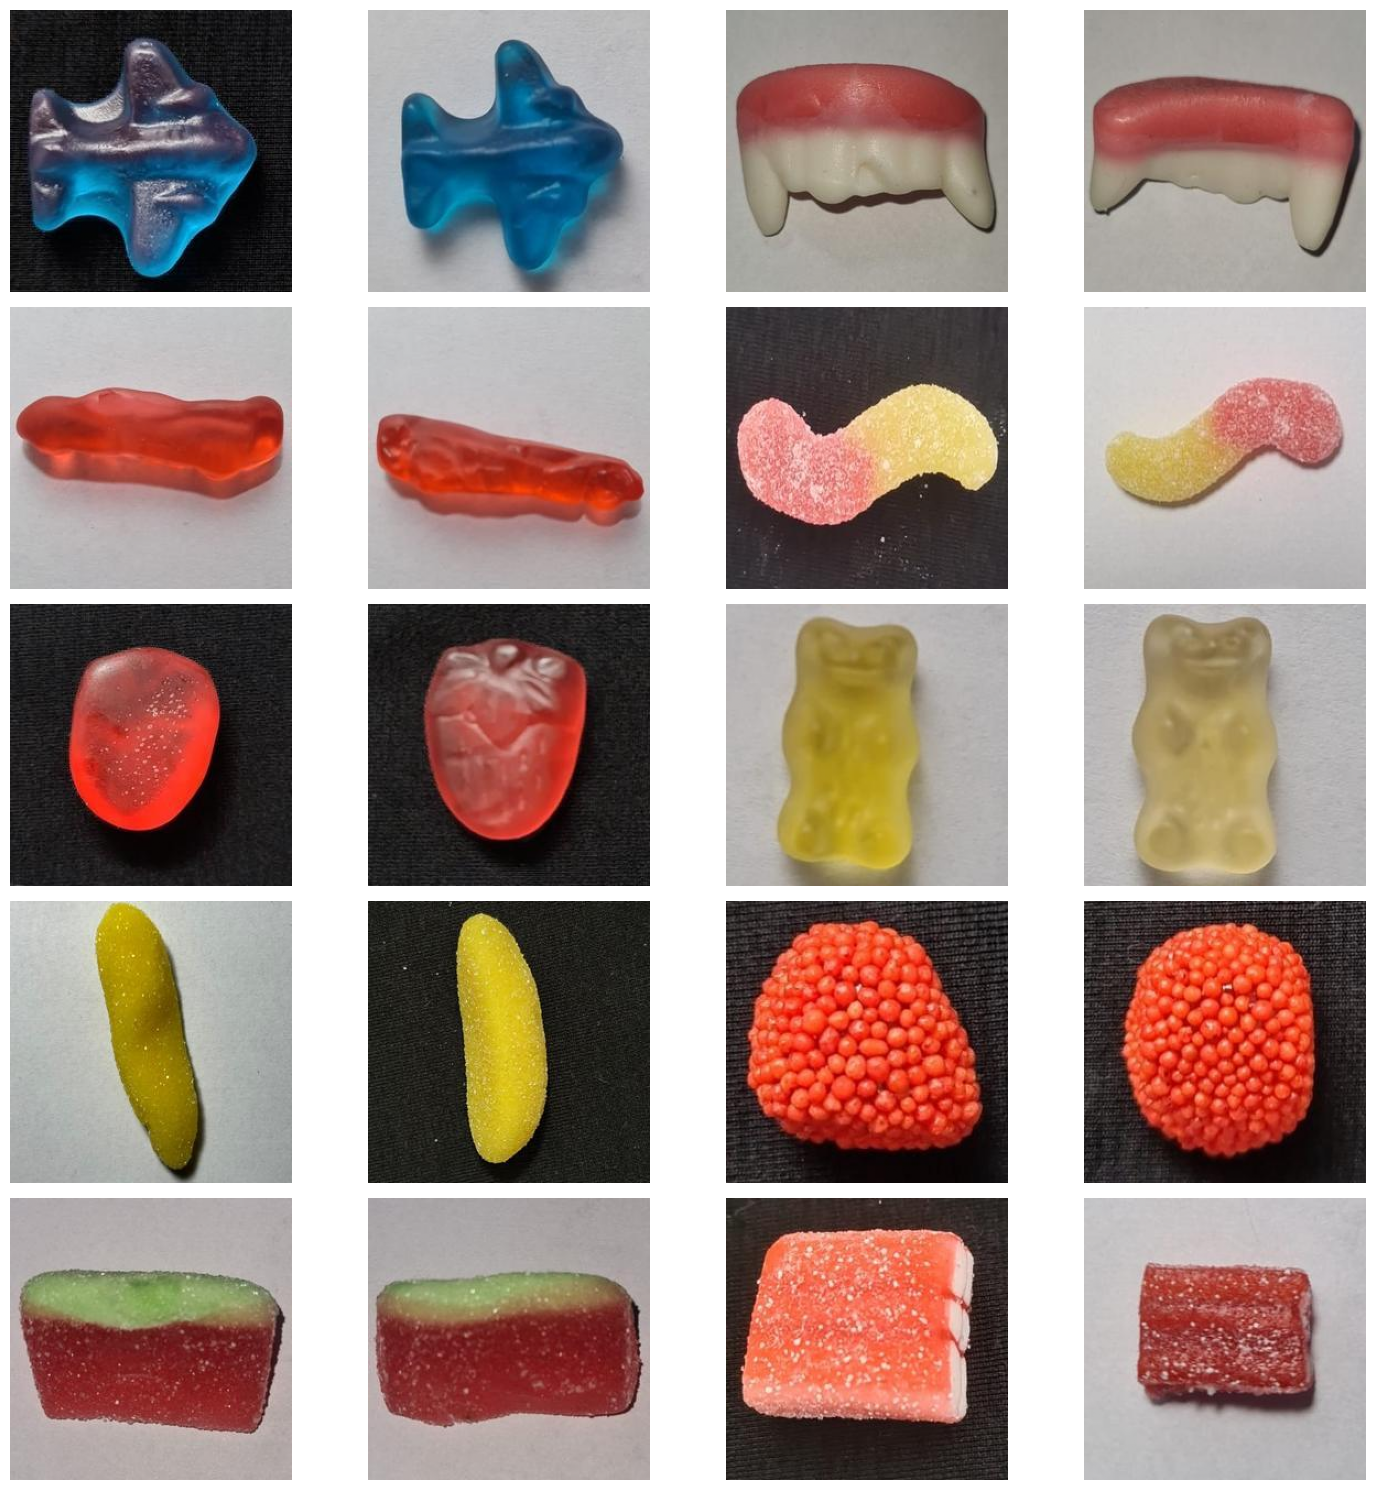

In [5]:
root_dir = '/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/resized'

show_mosaic_images(root_dir)

- Next Step: Rename all images to a specific format -> ```<CLASSID>-<IMG_SEQUENCE>-V1|V2-B|W.png```

In [14]:
root_dir = '/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/database/plane_class_4'

image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

print(image_files[3:6])

['00-04-V2-W.jpeg', '00-02-V2-B.jpg', '00-04-V1-W.jpeg']


### 2. Data Annotation
- Using **CVAT Web**, we performed bounding box segmentation for each class.

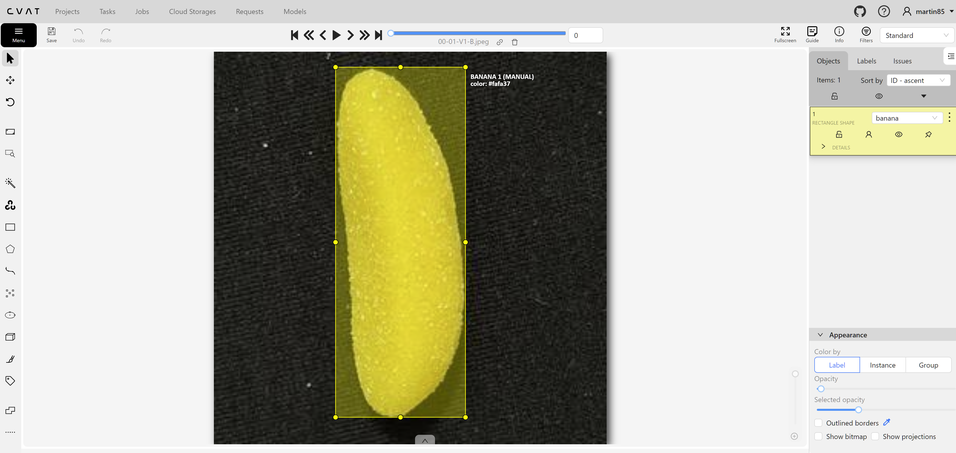

Image 1:
  ID: 0
  Name: 00-01-V1-B.jpeg
  Box Label: banana
  Coordinates: (79.30, 10.09) to (163.99, 238.41)
  Color: #fafa37

Image 2:
  ID: 1
  Name: 00-01-V2-B.jpeg
  Box Label: banana
  Coordinates: (71.49, 18.24) to (168.55, 232.22)
  Color: #fafa37

Image 3:
  ID: 2
  Name: 00-02-V1-B.jpeg
  Box Label: banana
  Coordinates: (38.27, 6.51) to (163.01, 250.79)
  Color: #fafa37



In [28]:
from scripts.fetch_annotations import show_first_3_annotations
from PIL import Image

img = Image.open('/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/docs/Banana_bounding_box_cvat_example.png')

# Resize the image
width, height = img.size
new_size = (width // 4, height // 4)
resized_img = img.resize(new_size, Image.Resampling.LANCZOS)

resized_img.show()

# Show the annotations created on the segmentatio bounding box stage
xml_file_path = '/home/mab0205/UTFPR/GitHub/DIP-Candy-Classification/annotations.xml'
show_first_3_annotations(xml_file_path)


### Preprocessing
We divided this stage in three steps:

    * Correction of inconsistencies
    * Data augmentation (expansion of the dataset)
    * Data normalization

In [10]:
from utils.dataset import CandyDataset
from utils.preprocessing import correct_background
from utils.normalization_plots import generate_image_statitics
from scripts.mosaico_generator import generate_mosaico_from_object


In [11]:
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'database', 'dataset')
# print(dataset_dir)

Some images with black background from the dataset have inconsistencies in the background, having variations in texture and brightness.\
This script corrects these inconsistencies, darkening and blurring the background to make it more uniform while keeping the object in the foreground.

In [12]:
data_path = os.path.join(dataset_dir, '0 - original')
preprocessed_dir = os.path.join(dataset_dir, '1 - preprocessed')

correct_background(data_path, preprocessed_dir)

### 3. Data augmentation 
- albumentations: The albumentations lib is designed to increase dataset variety by applying a series of random transformations to an image
- The functions used are:  

        1. SafeRotate: Rotate an image 
        2. Affine: Transformation with shear
        3. RandomRotate90: Randomly rote 90, 180, or 270 
        4. HorizontalFlip
        5. VerticalFlip

-  Extra Transfomations:

        1. RandomBrightnessContrast
        2. GaussianBlur
        3. HueSaturationValue: just using Saturation shifting 


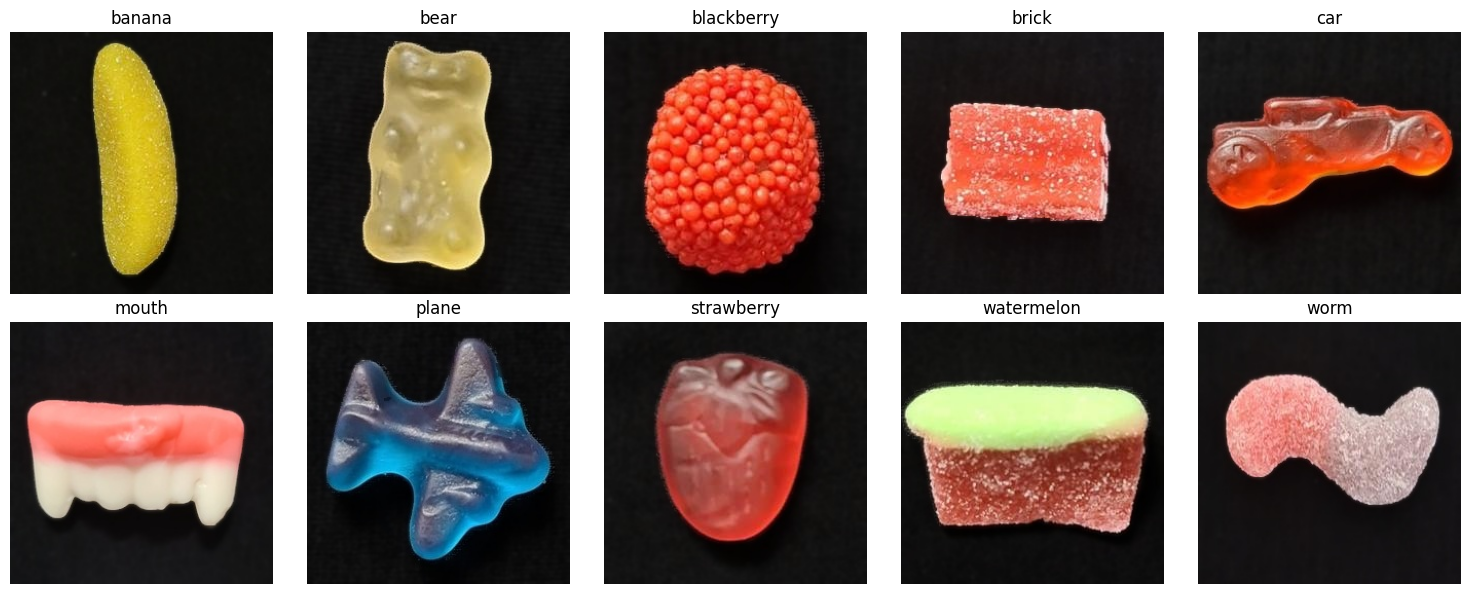

In [17]:
# Load dataset after background corrections
data_dir = os.path.join(dataset_dir, '1 - preprocessed')
dataset = CandyDataset(data_dir)

# augmentation
augmented_dir = os.path.join(dataset_dir, '2 - augmented')
dataset.augment_dataset()
dataset.save_annotations(augmented_dir)
dataset.export_images(augmented_dir)

cols = 5 
rows = 2
plt.figure(figsize=(15, 6))
for i, class_name in enumerate(classes):
    images_data = dataset.get_category_images(class_name)

    img = images_data[0]['image']

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4. Data Normalization
Data normalization in  (DIP)  involves equalizing histograms to enhance image quality.  The process aims to adjust the contrast and brightness of images for improved consistency and clarity.

Steps:

    - Histogram Equalization: Adjust the image's histogram to enhance contrast and distribute pixel values more evenly. 

    - Analyzing the Results: Evaluate the outcomes of histogram equalization to ensure that the adjustments meet the desired quality improvements and enhance the image effectively.

In [10]:
normalized_dir = os.path.join(dataset_dir, '3 - normalized')
dataset.normalize_dataset()
dataset.save_annotations(normalized_dir)
dataset.export_images(normalized_dir)

After extensive research, we found that the best way to understand our data was by using the RGB color model. Therefore, we created three lists, one for each channel.
We compared these channels in a single frequency graph over the pixel values. 

 - Mean Histogram - RGB Channels: the average pixel intensity distribution for the Red, Green, and Blue channels.
 - The histogram variance: indicates how much the intensity values vary across the images.
 - Mean Histogram - HSV Channels: shows intensity distribution for the Hue, Saturation, and Value channels in the HSV color space.

Class 'banana' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'bear' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'blackberry' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'brick' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'car' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'mouth' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'plane' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mean histogram calculated!
Class 'strawberry' statistics:
Average prototype calculated successfully!
Histogram variance calculated!
Mea

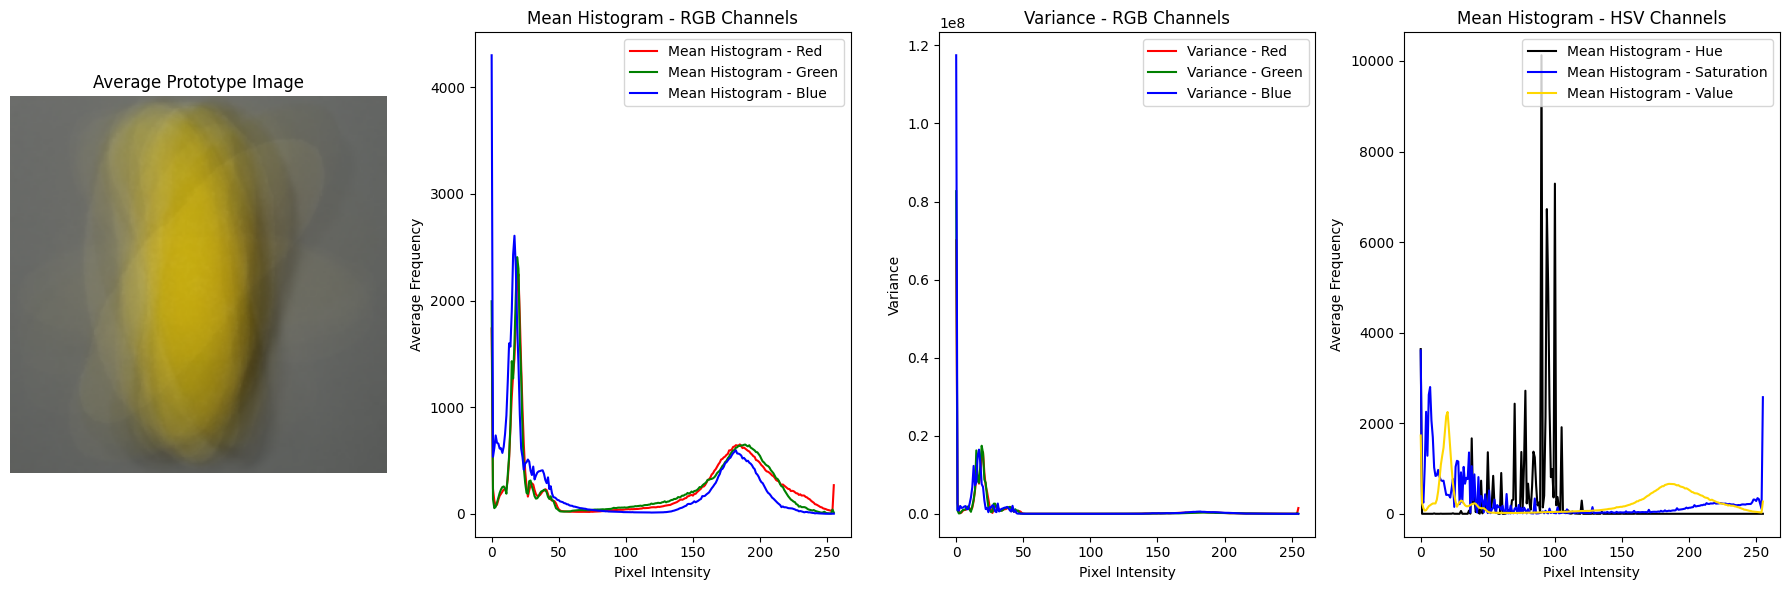

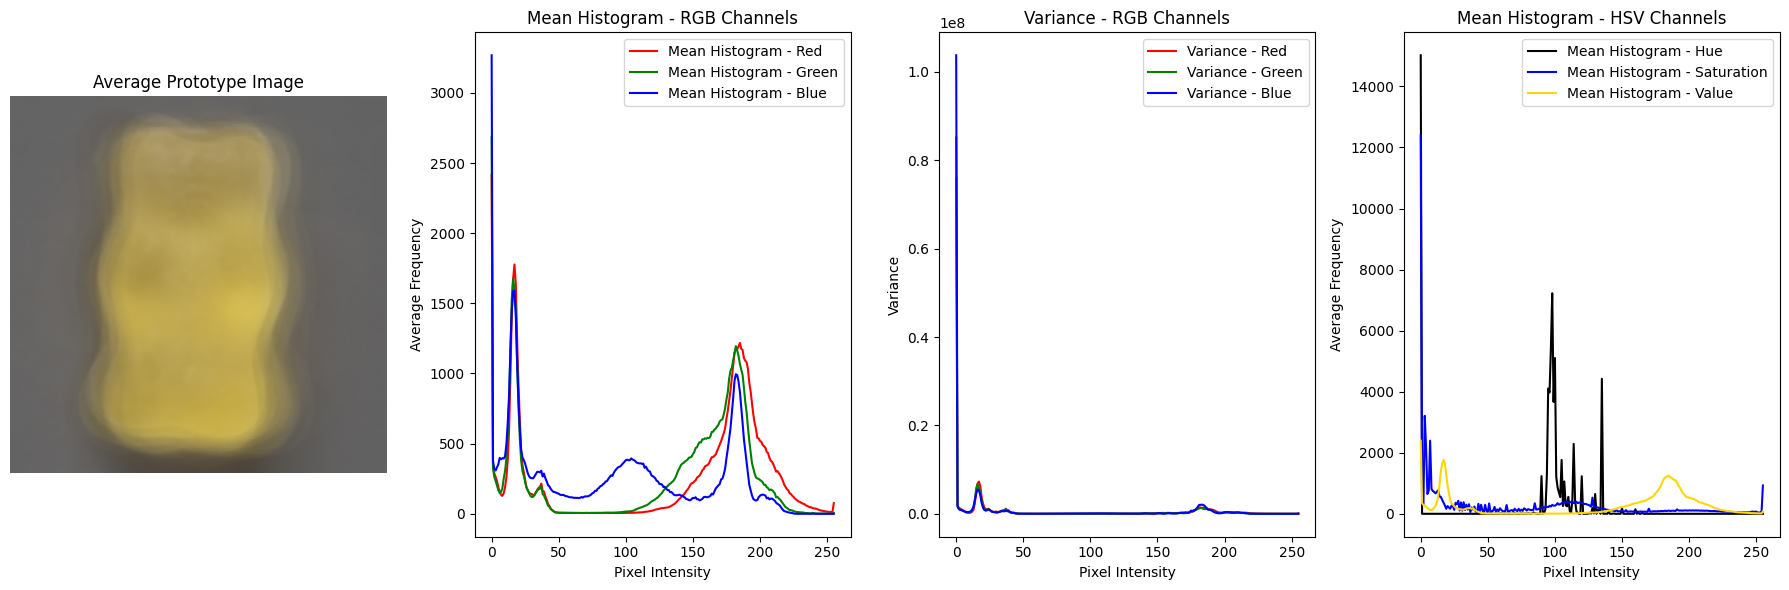

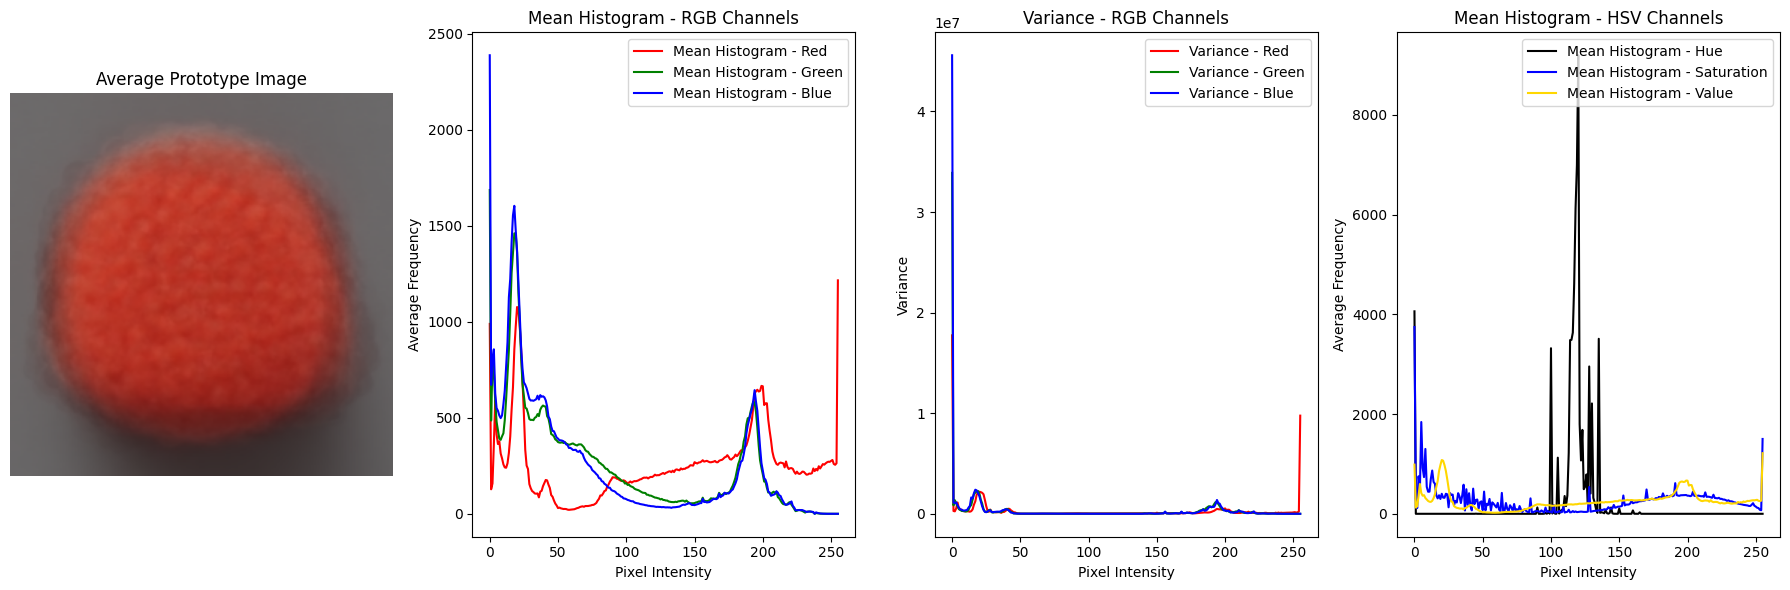

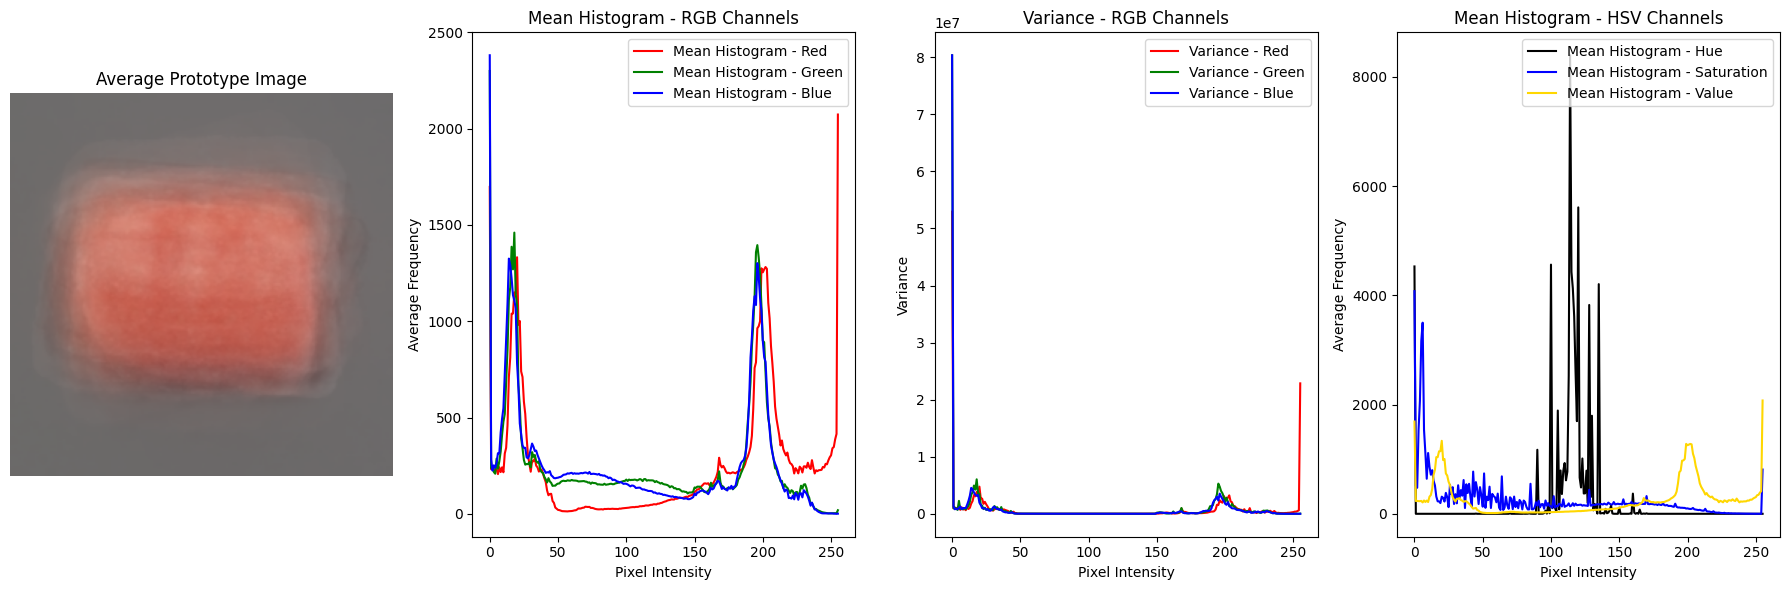

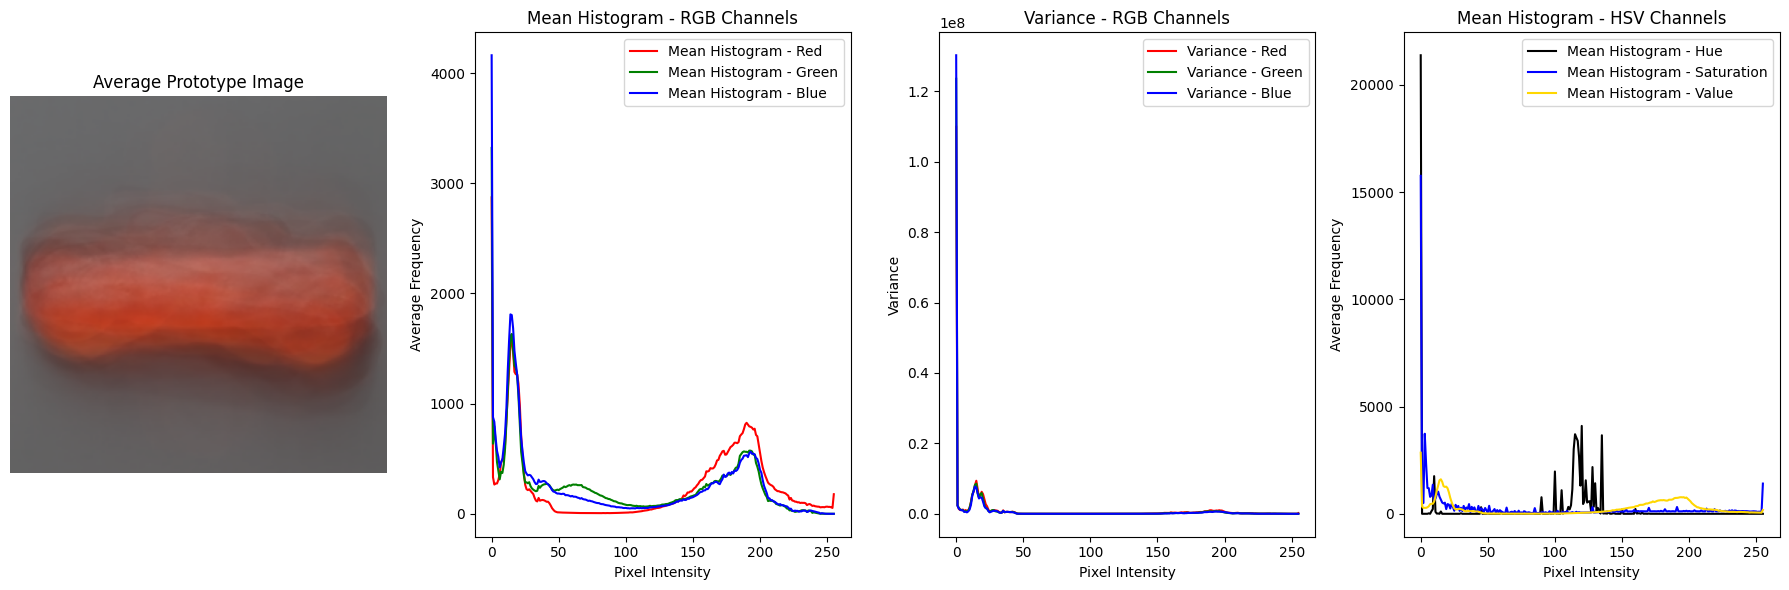

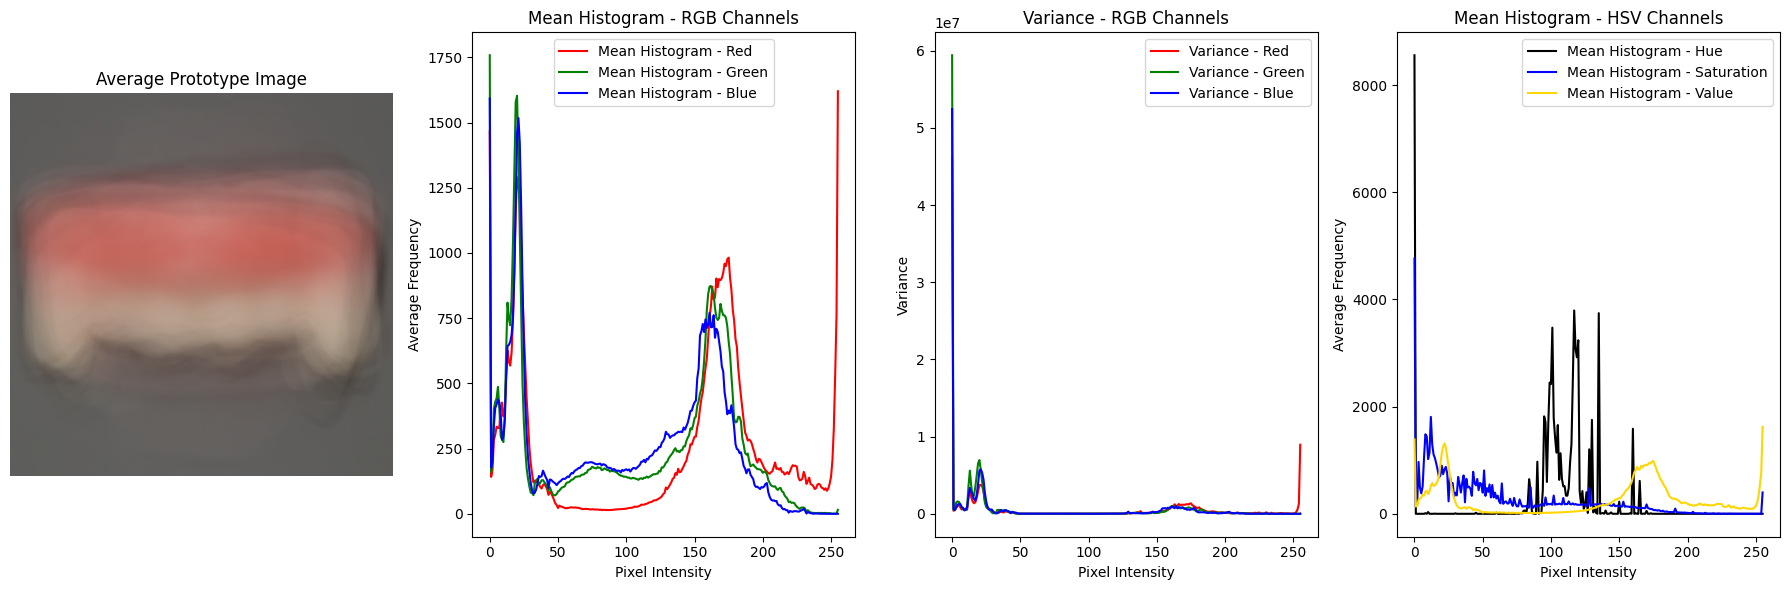

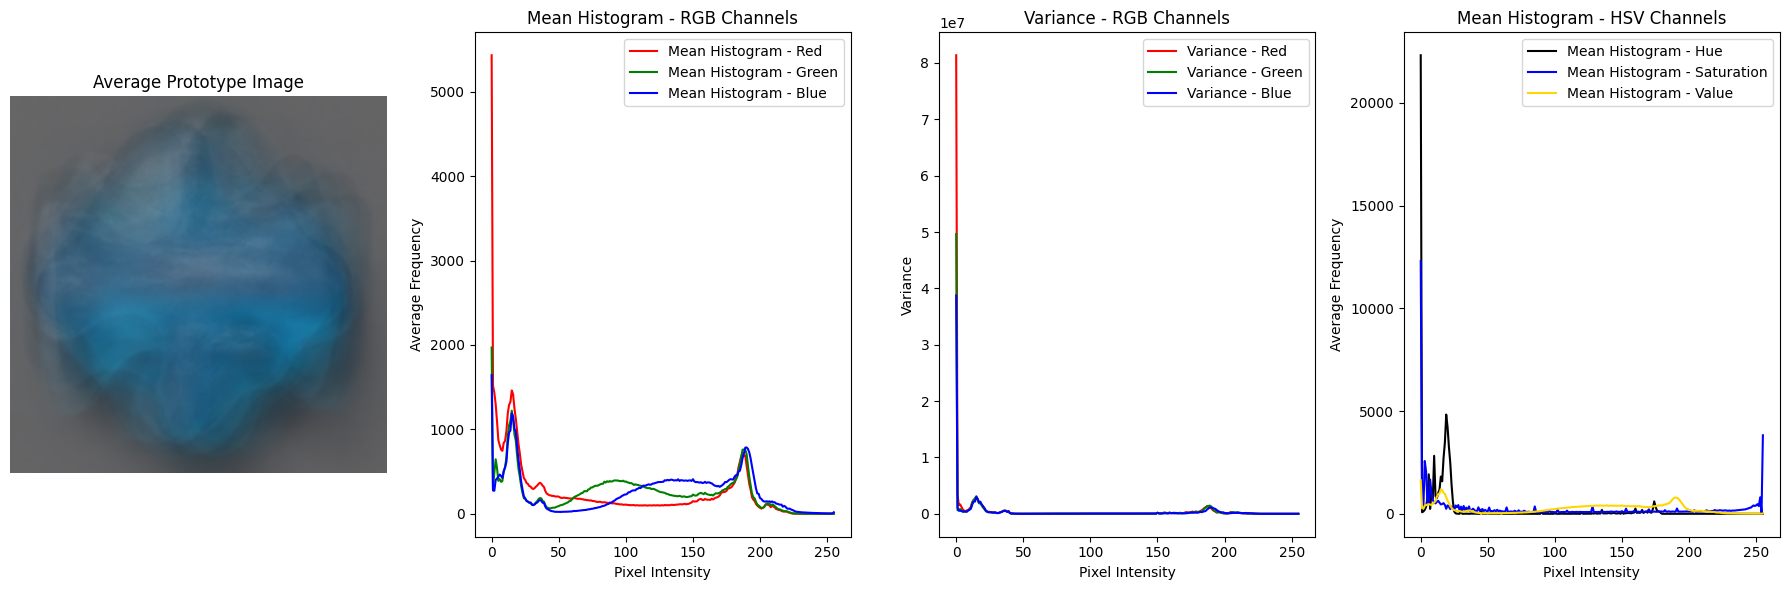

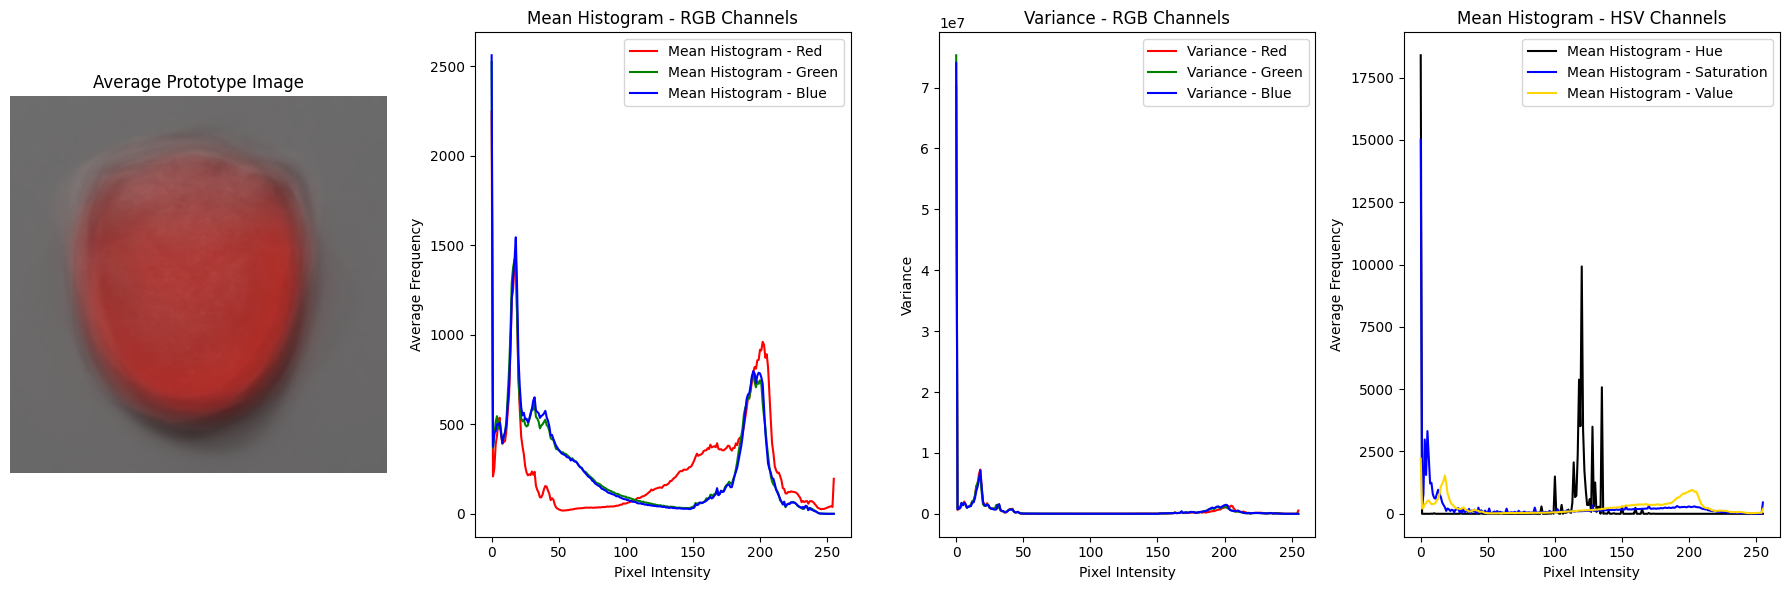

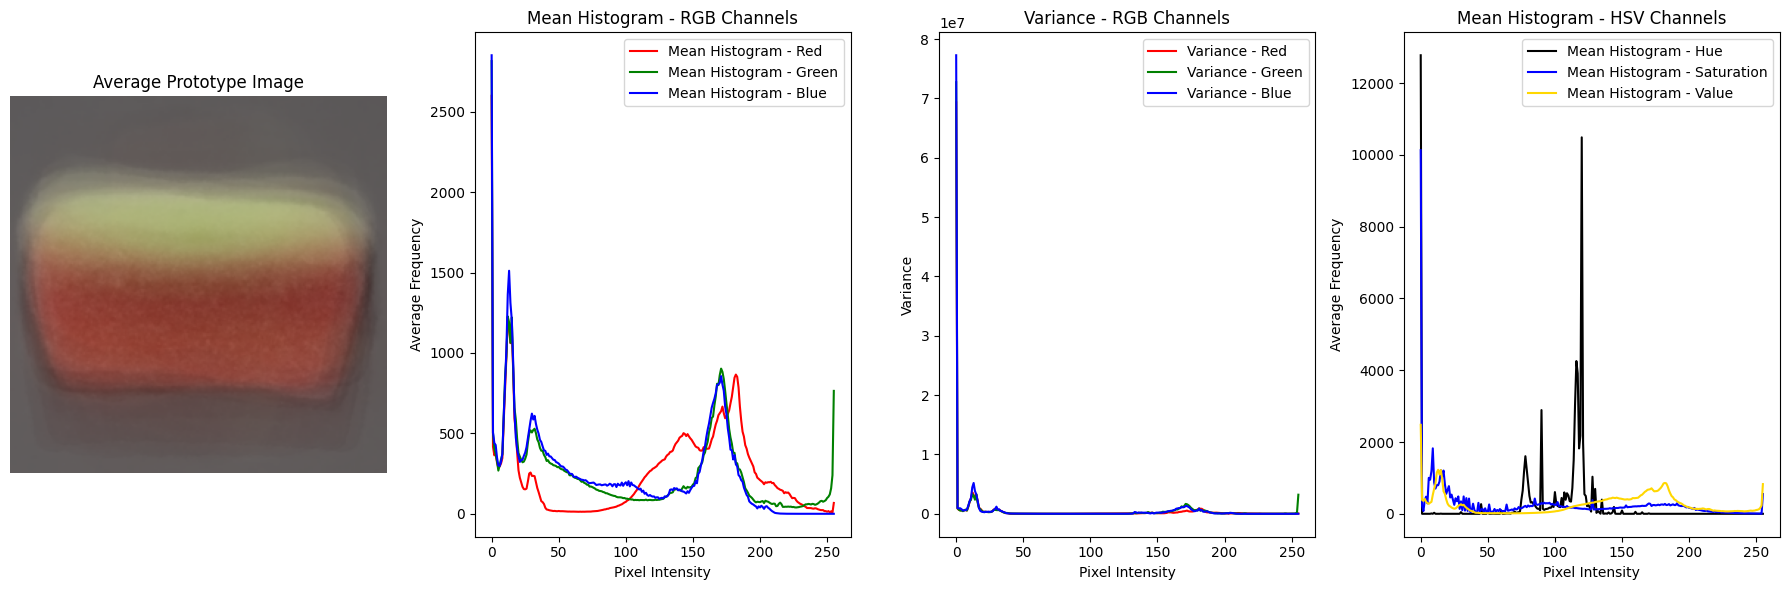

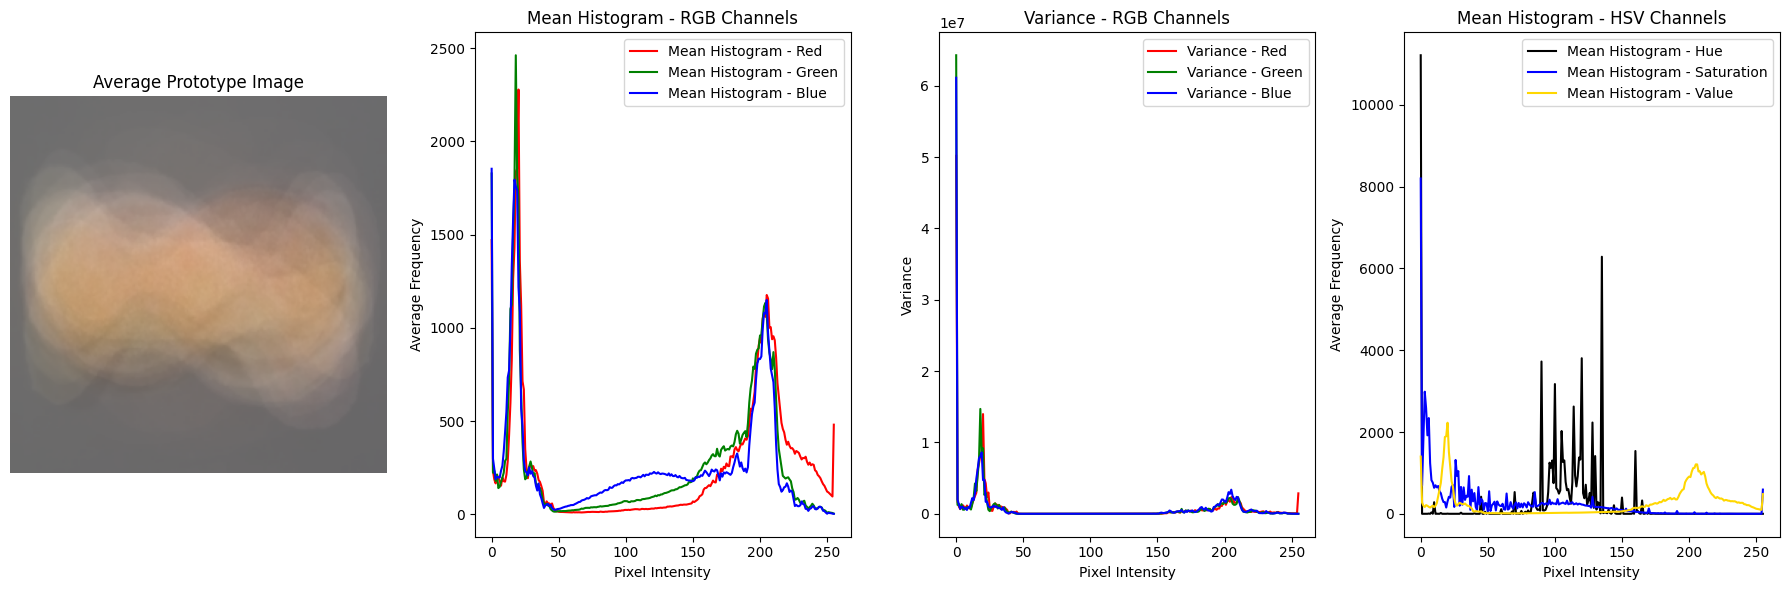

In [18]:
for class_name in classes:

    images_data = dataset.get_category_images(class_name)

    images = [d['image'] for d in images_data]
    masks = [d['mask'] for d in images_data]

    generate_image_statitics(images, class_name)

In this example:
- The prototipe: The image is a averaged version of several images of a yellow object (indicating a banana, due to the shape and color), layered on top of each other with some transparency. 
- Mean Histogram: Intensity between 0-50 , indicating a darker image background.

  Yellow color in the prototype image, since yellow is a combination of high red and green intensities

- Variance - RGB Channels: The variance is higher at lower intensities (corresponding to the dark background)

The yellow object’s color is relatively consistent across the images.

- Mean Histogram - HSV Channels :  

* The Hue (black line) has a spike around 100, which likely represents the dominant color of the object (yellow).
* The Saturation (blue line) and Value (yellow line) show distributions concentrated at lower intensities, which is typical for darker images.
* The yellow object's saturation is moderate, and the value (brightness) has a broader spread, indicating that there are both bright and somewhat muted yellow areas in the images.


### 5. Segmentation (Ground Truth)
In this section, we use the ground truth to evaluate the performance of our model in segmentation.

Ground truth is typically obtained by manually or automatically labeling the image.

*We created a binary representation of our image, where 0 represents the background and 1 represents the object.*

Manual Steps:

    - Part of the process was manual, using CVAT for approximately 25% of the masks.

Semi - Automatic Steps:

    - 75%: Using CVAT and SAM to identify key points and define the object’s shape.

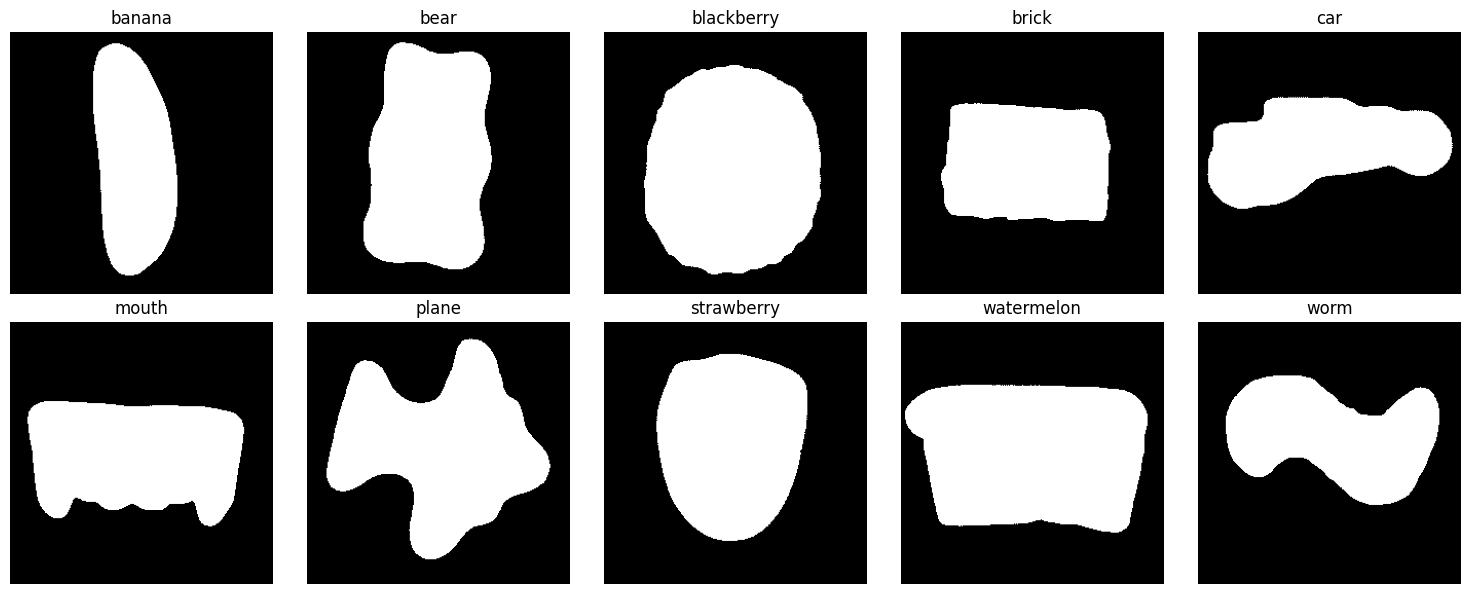

In [18]:
groud_truth_dir = os.path.join(dataset_dir, '4 - ground truth')
dataset.export_masks(groud_truth_dir)


### 6. Model Training
We test on many classification models. The model learns to map the input images to the corresponding
segmentation masks.

Configurations

    - train: 80%
    - test: 10%
    - val: 10%

Classification Models:

    - CNN
    -   
    -

### 7. Model Evaluation
The performance of the model is evaluated using metrics
such as accuracy, precision, recall, F1-score, and IoU.